In [28]:
import xarray as xr
import numpy as np
import datetime

In [3]:
#we want to run our model for different dates
t0_i = datetime.datetime(2018,7,22,0)
t0_f = datetime.datetime(2018,8,8,18)
delta_h = 6
# number of forecast steps
num_steps = 4 * 15 # 6h intervals

init_times = []
current_time = t0_i
while current_time <= t0_f:
    init_times.append(current_time)
    current_time += datetime.timedelta(hours=delta_h)

models = ['multimodel']

In [4]:
#load data
var='t2m'
var_inits_model = []
for model in models:
    print(model)
    var_inits = []
    for t0 in init_times:

        yyyymmddhh = t0.strftime('%Y%m%d%H')    
        file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_PGW_{model}_{yyyymmddhh}.nc'
        ds = xr.open_dataset(file)[var]
        var_inits.append(d)

    var_inits_model.append(xr.concat(var_inits, dim='init_time'))

merged_dataset = xr.concat(var_inits_model, dim='model')

    

multimodel


In [5]:
# Add coordinates for the new dimension
merged_dataset = merged_dataset.assign_coords(init_time=init_times)
merged_dataset = merged_dataset.assign_coords(model=models)

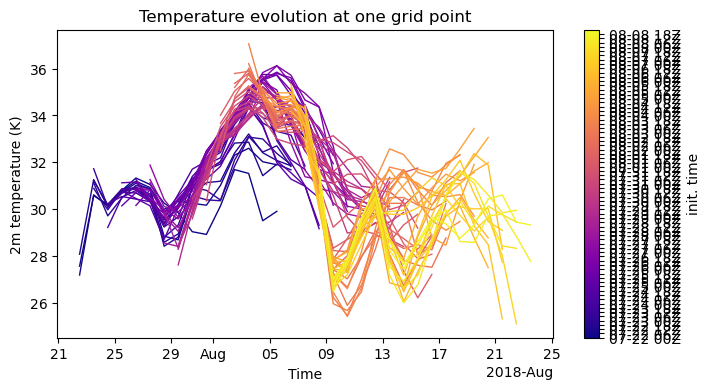

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def plot_temp_evolution(merged_dataset, init_times, models):
    """
    Plots the temperature evolution at one grid point along with shading between the 10th and 90th percentiles.

    Args:
    - merged_dataset (xarray.Dataset): A dataset containing the merged temperature data.
    - init_times (list): A list of initialization times.

    Returns:
    - None

    Example usage:
    plot_temp_evolution(merged_dataset, init_times)
    """

    # Define a colormap that starts from blue and gradually moves towards red
    cmap = plt.get_cmap('plasma')

    # Normalize initialization times to range from 0 to 1
    norm = plt.Normalize(0, len(init_times))

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(8,4))

    # Iterate over each initialization time
    for i, init in enumerate(init_times):
        for j, model in enumerate(models):
        # Calculate the color based on the normalized index
            color = cmap(norm(i))
            slice_data = merged_dataset.sel(model=model, init_time=init) -273.15
            # Select data slice and plot with custom color
            slice_data[2::4].plot(color=color, ax=ax, lw=1, ls='-')

    # Plot the average
    #ens_mean = merged_dataset.mean('init_time') -273.15 
    #ens_max = merged_dataset.max('init_time') -273.15
    #ens_min = merged_dataset.min('init_time') -273.15
    #ens_p90 = merged_dataset.quantile(0.75,'init_time') -273.15
    #ens_p10 = merged_dataset.quantile(0.25,'init_time') -273.15
#
    #ens_mean[2::4].plot(color='k', ax=ax, lw=2)
    #ax.fill_between(ens_min[2::4]['time'], ens_min[2::4], ens_max[2::4], color='k', alpha=0.1)
    #ax.fill_between(ens_min[2::4]['time'], ens_p10[2::4], ens_p90[2::4], color='k', alpha=0.2)

    # Customize the plot
    ax.set_title("Temperature evolution at one grid point")
    ax.set_xlabel("Time")
    ax.set_ylabel("2m temperature (K)")

    # Create a colorbar manually
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label="init. time")
    cbar.set_ticks(np.arange(0, len(init_times)))

    # Format the init_times to show only MM-DD HHUTC
    init_time_labels = [time.strftime('%m-%d %HZ') for time in init_times]
    cbar.set_ticklabels(init_time_labels)

    plt.show()

plot_temp_evolution(merged_dataset[:,:,:,200, -15], init_times, models)



In [7]:
#read era5 data
dir = '/home/bernatj/Data/my_data/era5/hourly/t2m/t2m-era5-hourly-2018*.nc'
t2m_era5 = xr.open_mfdataset(dir).t2m
t2m_era5 = t2m_era5.rename({'latitude' : 'lat', 'longitude' : 'lon'}) 


In [8]:
#load data

var='t2m'
var_inits = []
for t0 in init_times:

    yyyymmddhh = t0.strftime('%Y%m%d%H')    
    file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_{yyyymmddhh}.nc'
    ds = xr.open_dataset(file)[var]
    var_inits.append(ds)

merged_dataset_factual = xr.concat(var_inits, dim='init_time')
merged_dataset_factual = merged_dataset_factual.assign_coords(init_time=init_times)
    

In [9]:
def flip_lon_360_2_180(var_360, lon):
    """
    This function shifts the longitude dimension from [0,360] to [-180,180].
    """
    try:
        var_180 = var_360.assign_coords(lon=(lon + 180) % 360 - 180)
        var_180 = var_180.sortby(var_180.lon)
    except:
        var_180 = var_360.assign_coords(longitude=(lon + 180) % 360 - 180)
        var_180 = var_180.sortby(var_180.longitude)

    return var_180

import regionmask

def add_country_mask(ds: xr.Dataset, country: str="Spain") -> xr.Dataset:

    # get countries mask
    countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

    # create mask variable
    mask = countries.mask_3D(ds)

    # select Spain mask
    var_name = country.lower()
    ds[f"{var_name}_mask"] = mask.isel(region=(mask.names=="Spain")).squeeze().astype(np.int16)

    return ds

def add_land_mask(ds: xr.Dataset) -> xr.Dataset:

    # get land-sea-mask mask
    land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    # create land mask variable
    ds["land_mask"] = land_110.mask_3D(ds).squeeze().astype(np.int16)

    return ds

In [10]:
t2m_era5_max_iberia = add_land_mask(flip_lon_360_2_180(t2m_era5[12::24],t2m_era5.lon).sel(time=slice('2018-07-28','2018-08-15'), lat=slice(50,30),lon=slice(-12,9))).load() -273.15
t2m_era5_max_iberia_masked = t2m_era5_max_iberia.where(t2m_era5_max_iberia["land_mask"]==1, drop=True)

In [11]:
t2m_ai = merged_dataset[0]
t2m_ai_fac = merged_dataset_factual

In [12]:
t2m_ai_max_iberia = add_land_mask(flip_lon_360_2_180(t2m_ai[:,2::4], t2m_ai.lon).sel(lat=slice(50,30), lon=slice(-12,8))) -273.15
t2m_ai_max_iberia_masked = t2m_ai_max_iberia.where(t2m_ai_max_iberia["land_mask"]==1, drop=True)

In [13]:
t2m_ai_fac_max_iberia = add_land_mask(flip_lon_360_2_180(t2m_ai_fac[:,2::4], t2m_ai_fac.lon).sel(lat=slice(50,30), lon=slice(-12,8))) -273.15
t2m_ai_fac_max_iberia_masked = t2m_ai_fac_max_iberia.where(t2m_ai_fac_max_iberia["land_mask"]==1, drop=True)

In [17]:
t2m_ai_max_iberia_leadtime = xr.DataArray(dims=("lead_time", "time", "lat", "lon"), coords={"lead_time": np.arange(0,15*24,6), "time": t2m_ai_max_iberia.time, "lat": t2m_ai_max_iberia.lat, "lon": t2m_ai_max_iberia.lon })
t2m_ai_fac_max_iberia_leadtime = xr.DataArray(dims=("lead_time", "time", "lat", "lon"), coords={"lead_time": np.arange(0,15*24,6), "time": t2m_ai_max_iberia.time, "lat": t2m_ai_max_iberia.lat, "lon": t2m_ai_max_iberia.lon })

# Loop to assign values
for t in t2m_ai_max_iberia_leadtime.time:
    for lt in t2m_ai_max_iberia_leadtime.lead_time:
        it = t - np.timedelta64(int(lt), 'h')
        try:
            print(t.values)
            t2m_ai_max_iberia_leadtime.loc[{"lead_time": lt, "time": t}] = t2m_ai_max_iberia.sel(init_time=it, time=t)
            t2m_ai_fac_max_iberia_leadtime.loc[{"lead_time": lt, "time": t}] = t2m_ai_fac_max_iberia.sel(init_time=it, time=t)
        except:
            t2m_ai_max_iberia_leadtime.loc[{"lead_time": lt, "time": t}] = np.nan
            t2m_ai_fac_max_iberia_leadtime.loc[{"lead_time": lt, "time": t}] = np.nan

2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22

In [18]:
#average over iberia:
t2m_era5_max_iberia_avg = t2m_era5_max_iberia_masked.sel(lat=slice(43,36),lon=slice(-9,3)).mean('lon').mean('lat')
t2m_ai_max_iberia_avg = t2m_ai_max_iberia_masked.sel(lat=slice(43,36),lon=slice(-9,3)).mean('lon').mean('lat')
t2m_ai_fac_max_iberia_avg = t2m_ai_fac_max_iberia_masked.sel(lat=slice(43,36),lon=slice(-9,3)).mean('lon').mean('lat')

In [19]:
diff_atrib_models = t2m_ai_fac_max_iberia_avg.mean('init_time') - t2m_ai_max_iberia_avg.mean('init_time')

In [20]:
t2m_ai_max_iberia_avg_leadtime = xr.DataArray(dims=("lead_time", "time"), coords={"lead_time": np.arange(0,15*24,6), "time": t2m_ai_max_iberia_avg.time})
t2m_ai_fac_max_iberia_avg_leadtime = xr.DataArray(dims=("lead_time", "time"), coords={"lead_time": np.arange(0,15*24,6), "time": t2m_ai_max_iberia_avg.time})

# Loop to assign values
for t in t2m_ai_max_iberia_avg.time:
    for lt in t2m_ai_max_iberia_avg_leadtime.lead_time:
        it = t - np.timedelta64(int(lt), 'h')
        try:
            print(t.values)
            t2m_ai_max_iberia_avg_leadtime.loc[{"lead_time": lt, "time": t}] = t2m_ai_max_iberia_avg.sel(init_time=it, time=t)
            t2m_ai_fac_max_iberia_avg_leadtime.loc[{"lead_time": lt, "time": t}] = t2m_ai_fac_max_iberia_avg.sel(init_time=it, time=t)
        except:
            t2m_ai_max_iberia_avg_leadtime.loc[{"lead_time": lt, "time": t}] = np.nan
            t2m_ai_fac_max_iberia_avg_leadtime.loc[{"lead_time": lt, "time": t}] = np.nan


2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22T12:00:00.000000000
2018-07-22

In [29]:
diff_pgw_leadtime = t2m_ai_fac_max_iberia_avg_leadtime - t2m_ai_max_iberia_avg_leadtime

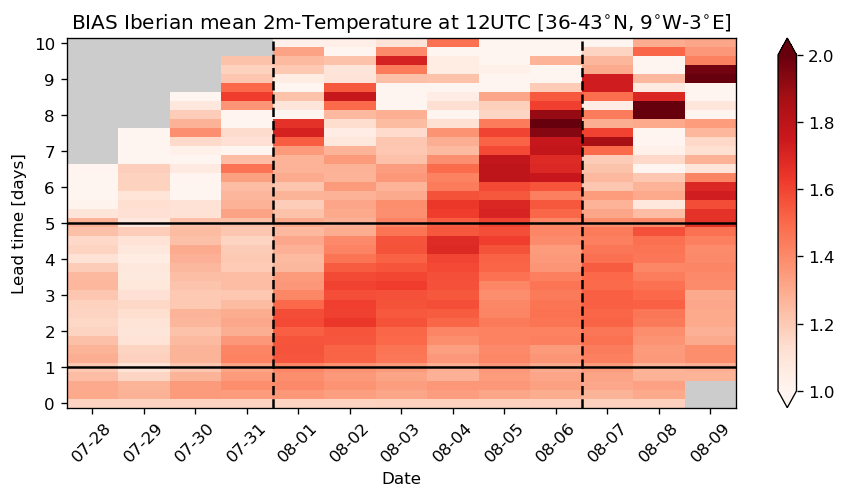

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure with desired size
fig, ax = plt.subplots(figsize=(9, 4))
ax.set_facecolor('0.8')
# Plot t2m_era5_max_iberia_avg
diff_pgw_leadtime[0:41,6:19].plot(ax=ax, cmap='Reds', vmax=2, vmin=1, extend='both')

# Add vertical lines at August 1 and August 7
# Convert date strings to datetime objects
aug_1 = pd.to_datetime('2018-08-01')
aug_7 = pd.to_datetime('2018-08-07')

# Add a filled background between the vertical lines
ax.axvline(x=aug_1, color='k', linestyle='--')
ax.axvline(x=aug_7, color='k', linestyle='--')

ax.axhline(y=1*24, color='k', linestyle='-')
ax.axhline(y=5*24, color='k', linestyle='-')


# Set the x-axis tick positions to the middle of the raster boxes
ax.set_yticks(diff_pgw_leadtime[0:41:4,6:19].lead_time)
# Set the tick labels to the desired dates
labels = [(value.values/24) for value in diff_pgw_leadtime[0:41:4,6:19].lead_time]
ax.set_yticklabels(int(label) for label in labels)

# Set the x-axis tick positions to the middle of the raster boxes
ax.set_xticks(diff_pgw_leadtime[:,6:19].time)
# Set the tick labels to the desired dates
ax.set_xticklabels(diff_pgw_leadtime[:,6:19].time.dt.strftime('%m-%d').values)

# Rotate the tick labels for better readability
plt.xticks(rotation=45)

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Lead time [days]')
ax.set_title('BIAS Iberian mean 2m-Temperature at 12UTC [36-43$^{\circ}$N, 9$^{\circ}$W-3$^{\circ}$E]')

plt.savefig('Atributtion_leadtime_vs_time_2018HW_Iberia_FourCastNet_mmm_pgw_v2.pdf',bbox_inches='tight')
plt.savefig('Atributtion_leadtime_vs_time_2018HW_Iberia_FourCastNet_mmm_pgw_v2.png')

In [31]:
# Plot the average
lead_time_slice=slice(1*24,6*24)
ens_mean = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).mean(dim=['lead_time'])  
ens_max = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).max(dim=['lead_time']) 
ens_min = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).min(dim=['lead_time']) 
ens_p95 = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).quantile(0.95,dim=['lead_time']) 
ens_p5 = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).quantile(0.05,dim=['lead_time']) 
ens_p75 = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).quantile(0.75,dim=['lead_time']) 
ens_p25 = t2m_ai_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).quantile(0.25,dim=['lead_time']) 

ens_mean_fac = t2m_ai_fac_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).mean(dim=['lead_time'])  
ens_max_fac = t2m_ai_fac_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).max(dim=['lead_time']) 
ens_min_fac = t2m_ai_fac_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).min(dim=['lead_time']) 
ens_p95_fac = t2m_ai_fac_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).quantile(0.95,dim=['lead_time']) 
ens_p5_fac = t2m_ai_fac_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).quantile(0.05,dim=['lead_time']) 
ens_p75_fac = t2m_ai_fac_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).quantile(0.75,dim=['lead_time']) 
ens_p25_fac = t2m_ai_fac_max_iberia_avg_leadtime.sel(lead_time=lead_time_slice).quantile(0.25,dim=['lead_time']) 

/home/bernatj/miniconda3/envs/bayesevt_ai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/bernatj/miniconda3/envs/bayesevt_ai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


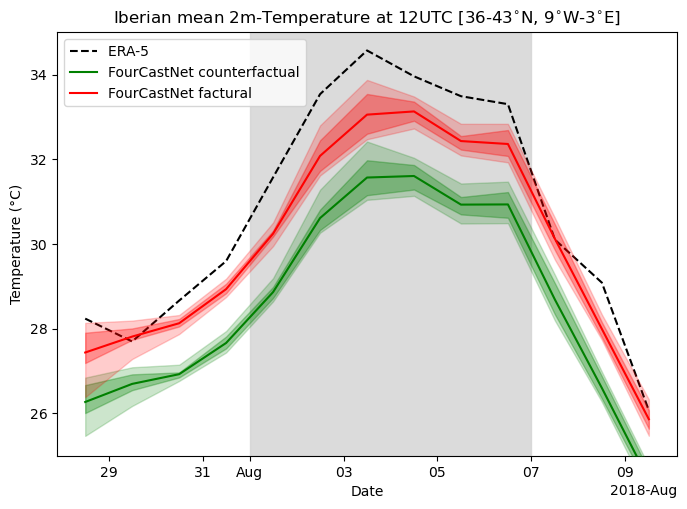

In [172]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure with desired size
fig, ax = plt.subplots(figsize=(8, 5.5))

# Plot t2m_era5_max_iberia_avg
t2m_era5_max_iberia_avg[0:13].plot(ax=ax, label='ERA-5 ', color='k', linestyle='--')

# Plot t2m_ai_max_iberia_avg
ens_mean[6:19].plot(ax=ax, label='FourCastNet counterfactual', color='g', linestyle='-', zorder=102)
ax.fill_between(ens_p5['time'][6:19], ens_p5[6:19], ens_p95[6:19], color='g', alpha=0.2, zorder=101)
ax.fill_between(ens_p5['time'][6:19], ens_p25[6:19], ens_p75[6:19], color='g', alpha=0.3, zorder=100)
#ens_max[6:19].plot(ax=ax, color='g', linestyle=':', zorder=102)
#ens_min[6:19].plot(ax=ax, color='g', linestyle=':', zorder=102)

#factual world
ens_mean_fac[6:19].plot(ax=ax, label='FourCastNet factural', color='r', linestyle='-', zorder=202)
ax.fill_between(ens_min_fac['time'][6:19], ens_p5_fac[6:19], ens_p95_fac[6:19], color='r', alpha=0.2, zorder=201)
ax.fill_between(ens_min_fac['time'][6:19], ens_p25_fac[6:19], ens_p75_fac[6:19], color='r', alpha=0.3, zorder=200)
#ens_max_fac[6:19].plot(ax=ax, color='r', linestyle=':', zorder=102)
#ens_min_fac[6:19].plot(ax=ax, color='r', linestyle=':', zorder=102)


# Add vertical lines at August 1 and August 7
# Convert date strings to datetime objects
aug_1 = pd.to_datetime('2018-08-01')
aug_7 = pd.to_datetime('2018-08-07')

# Add a filled background between the vertical lines
ax.axvspan(aug_1, aug_7, color='lightgray', alpha=0.8)

# Add legend
ax.legend(fontsize=10)

ax.set_ylim([25,35])

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Iberian mean 2m-Temperature at 12UTC [36-43$^{\circ}$N, 9$^{\circ}$W-3$^{\circ}$E]')

plt.savefig('plot_HW2018_atribution_pgw_mmm_Iberian_landmean_leadtime_1-6days.pdf')


In [32]:
#plot diff eveolution and significance
lead_time_slice=slice(1*24,6*24)

diff_pgw_time_mean = diff_pgw_leadtime.sel(lead_time=lead_time_slice).mean('lead_time')
diff_pgw_time_max = diff_pgw_leadtime.sel(lead_time=lead_time_slice).max(dim=['lead_time']) 
diff_pgw_time_min = diff_pgw_leadtime.sel(lead_time=lead_time_slice).min(dim=['lead_time']) 
diff_pgw_time_p95 = diff_pgw_leadtime.sel(lead_time=lead_time_slice).quantile(0.95,dim=['lead_time']) 
diff_pgw_time_p5 = diff_pgw_leadtime.sel(lead_time=lead_time_slice).quantile(0.05,dim=['lead_time']) 
diff_pgw_time_p75 = diff_pgw_leadtime.sel(lead_time=lead_time_slice).quantile(0.75,dim=['lead_time']) 
diff_pgw_time_p25 = diff_pgw_leadtime.sel(lead_time=lead_time_slice).quantile(0.25,dim=['lead_time']) 

/home/bernatj/miniconda3/envs/bayesevt_ai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0.5, 1.0, 'Iberian mean 2m-Temperature at 12UTC [36-43$^{\\circ}$N, 9$^{\\circ}$W-3$^{\\circ}$E]')

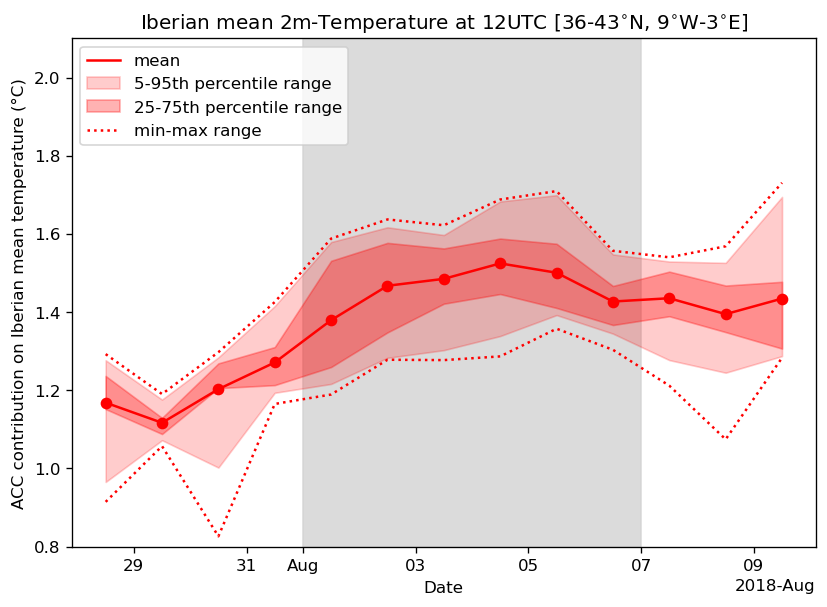

In [126]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure with desired size
fig, ax = plt.subplots(figsize=(8, 5.5))

# Plot t2m_ai_max_iberia_avg
color='red'
diff_pgw_time_mean[6:19].plot(ax=ax, color=color, linestyle='-', zorder=102, label='mean')
diff_pgw_time_mean[6:19].plot.scatter(ax=ax, color=color, linestyle='-', zorder=102)
ax.fill_between(diff_pgw_time_p5['time'][6:19], diff_pgw_time_p5[6:19], diff_pgw_time_p95[6:19], color=color, alpha=0.2, zorder=101,label='5-95th percentile range')
ax.fill_between(diff_pgw_time_p5['time'][6:19], diff_pgw_time_p25[6:19], diff_pgw_time_p75[6:19], color=color, alpha=0.3, zorder=100,label='25-75th percentile range')
diff_pgw_time_max[6:19].plot(ax=ax, color=color, linestyle=':', zorder=102,label='min-max range')
diff_pgw_time_min[6:19].plot(ax=ax, color=color, linestyle=':', zorder=102)


# Add vertical lines at August 1 and August 7
# Convert date strings to datetime objects
aug_1 = pd.to_datetime('2018-08-01')
aug_7 = pd.to_datetime('2018-08-07')

# Add a filled background between the vertical lines
ax.axvspan(aug_1, aug_7, color='lightgray', alpha=0.8)

# Add legend
ax.legend(fontsize=10,loc='upper left')

ax.set_ylim([0.8,2.1])

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('ACC contribution on Iberian mean temperature (°C)')
ax.set_title('Iberian mean 2m-Temperature at 12UTC [36-43$^{\circ}$N, 9$^{\circ}$W-3$^{\circ}$E]')

In [123]:
#calculate bias:
lead_time_slice=slice(1*24,6*24)
ens_mean_iberia = t2m_ai_max_iberia_leadtime.sel(lead_time=lead_time_slice).mean('lead_time')
ens_mean_iberia_fac = t2m_ai_fac_max_iberia_leadtime.sel(lead_time=lead_time_slice).mean('lead_time')  

t2m_ai_bias_iberia = (ens_mean_iberia_fac - t2m_era5_max_iberia).load()
t2m_ai_pgw_iberia = (ens_mean_iberia_fac - ens_mean_iberia).load()

In [124]:
#significance
from scipy import stats
sample1= t2m_ai_max_iberia_leadtime.sel(lead_time=lead_time_slice).values
sample2= t2m_ai_fac_max_iberia_leadtime.sel(lead_time=lead_time_slice).values

_, p_value = stats.ttest_ind(sample1, sample2, axis=0)

In [93]:
data.shape

(13, 81, 81)

In [37]:
#calculate bias:
ens_mean_iberia = t2m_ai_max_iberia.mean('init_time') 
ens_mean_iberia_fac = t2m_ai_fac_max_iberia.mean('init_time')  

t2m_ai_bias_iberia = (ens_mean_iberia_fac - t2m_era5_max_iberia).load()
t2m_ai_pgw_iberia = (ens_mean_iberia_fac - ens_mean_iberia).load()

/tmp/ipykernel_3080181/1433411955.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)


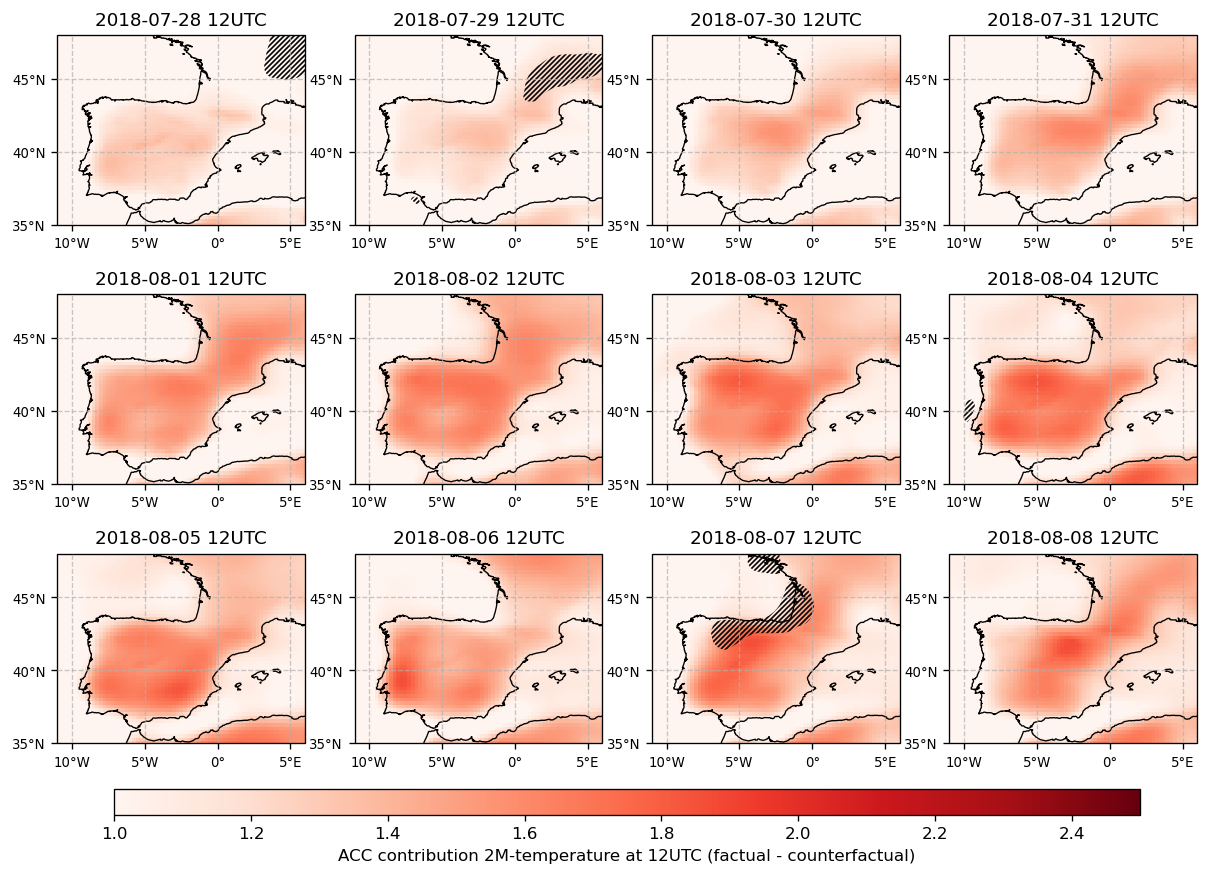

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

data= t2m_ai_pgw_iberia[6:19] 
p_val = p_value[6:19]
# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(10,8.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

#lev = np.arange(-3,3.1,0.25)
lev = np.arange(16,42.1,1)
lev2 = np.arange(5300,6000,80)
colors = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = data.lat, data.lon
nLons = np.arange(-180, 181, 5)
nLats = np.arange(-90, 91, 5)

# Loop through subplots
for i, ax in enumerate(axes.flatten()):


    ax.set_title( data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)

    ax.set_xticks(nLons, crs=ccrs.PlateCarree())
    ax.set_yticks(nLats, crs=ccrs.PlateCarree())
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim([35, 48])
    ax.set_xlim([-11, 6])
    
    ax.set_facecolor('0.9')
    ax.coastlines(lw=0.8, color='k')  
    ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

    # format the ticks as e.g 60°W
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    ax.set_aspect(1)

    # Explicitly pass the ax parameter to contourf
    #h = ax.contourf(lon, lat, data[i], cmap='Spectral_r', levels=lev, extend='both', alpha=1.0) 
    h = ax.pcolormesh(lon, lat, data[i], cmap='Reds', vmax=2.5, vmin=1)
    p = ax.contourf(lon, lat, p_val[i], colors='none', levels=[0.01,1], hatches=['////////',''])

# Adjust size
f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.0, right=0.95, bottom=0.05, top=0.95)

# Add common colorbar
cbar = plt.colorbar(h, ax=axes, label='ACC contribution 2M-temperature at 12UTC (factual - counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)
#cbar = plt.colorbar(h, ax=axes, label='BIAS in 2M-Temperature at 12UTC FourcastNet (Factual - Counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

#save figure
#plt.savefig('2018HW_Iberia_pannel_bias_FourCastNet_wrt_ERA5.pdf',bbox_inches='tight')
plt.savefig('2018HW_Iberia_pannel_diff_FourCastNet_factual-counterfactual-leadtime_1-6d.pdf',bbox_inches='tight')

/tmp/ipykernel_3080181/908674746.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)


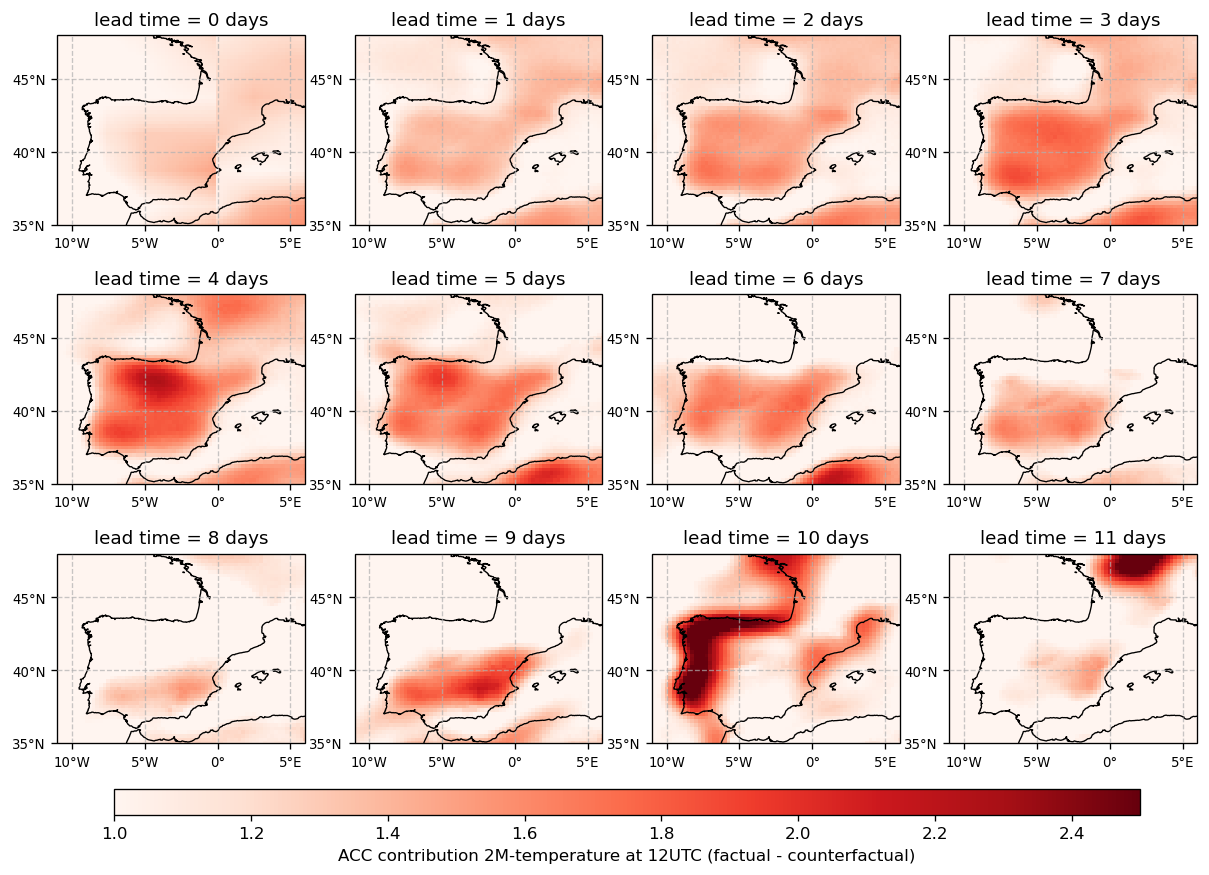

In [59]:
#let's plot same day for each lag

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

data= (t2m_ai_fac_max_iberia_leadtime.sel(time='2018-08-04') - t2m_ai_max_iberia_leadtime.sel(time='2018-08-04')).squeeze()

# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(10,8.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

lat, lon = data.lat, data.lon
nLons = np.arange(-180, 181, 5)
nLats = np.arange(-90, 91, 5)

# Loop through subplots
for i, ax in enumerate(axes.flatten()):
    try:
        ax.set_title(f'lead time = {int(data.lead_time.values[i*4]/24)} days', fontsize=11)

        ax.set_xticks(nLons, crs=ccrs.PlateCarree())
        ax.set_yticks(nLats, crs=ccrs.PlateCarree())
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_ylim([35, 48])
        ax.set_xlim([-11, 6])
    
        ax.set_facecolor('0.9')
        ax.coastlines(lw=0.8, color='k')  
        ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

        # format the ticks as e.g 60°W
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())

        ax.set_aspect(1)

        # Explicitly pass the ax parameter to contourf
        #h = ax.contourf(lon, lat, data[i], cmap='Spectral_r', levels=lev, extend='both', alpha=1.0) 
        h = ax.pcolormesh(lon, lat, data[i*4], cmap='Reds', vmax=2.5, vmin=1)
    except:
        f.delaxes(axes.flatten()[i])

# Adjust size
f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.0, right=0.95, bottom=0.05, top=0.95)

# Add common colorbar
cbar = plt.colorbar(h, ax=axes, label='ACC contribution 2M-temperature at 12UTC (factual - counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)
#cbar = plt.colorbar(h, ax=axes, label='BIAS in 2M-Temperature at 12UTC FourcastNet (Factual - Counterfactual)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

#save figure
#plt.savefig('2018HW_Iberia_pannel_bias_FourCastNet_wrt_ERA5.pdf',bbox_inches='tight')
plt.savefig('2018HW_Iberia_pannel_diff_FourCastNet_factual-counterfactual-2018-08-04-leadtime-dependence.pdf',bbox_inches='tight')


In [68]:
lead_time_slice=slice(1*24,6*24)
ens_std_iberia = t2m_ai_fac_max_iberia_leadtime.sel(lead_time=lead_time_slice).std('lead_time')
ens_std_iberia

<xarray.DataArray (time: 33, lat: 81, lon: 81)> Size: 2MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.05275726, 0.05686573, 0.06360908, ..., 0.57883963,
         0.58962306, 0.60654213],
        [0.04576352, 0.06133843, 0.0701126 , ..., 0.53267335,
         0.53305893, 0.52896576],
        [0.04905404, 0.06675437, 0.07918242, ..., 0.48648373,
         0.47366794, 0.46751245],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * time     (time) datetime64[ns] 264B 2018-07-22T12:00:00 ... 2018-08-23T12...
  * lat      (lat) float64 648B 50.0 49.75 49.5 49.25 ... 30.75 30.5 30.25 30.0
  * lon      (lon) float64 648B -12.0 -11.75 -11.5 -11.25 ... 7.25 7.5 7.75 8.0

/tmp/ipykernel_3080181/113293027.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)


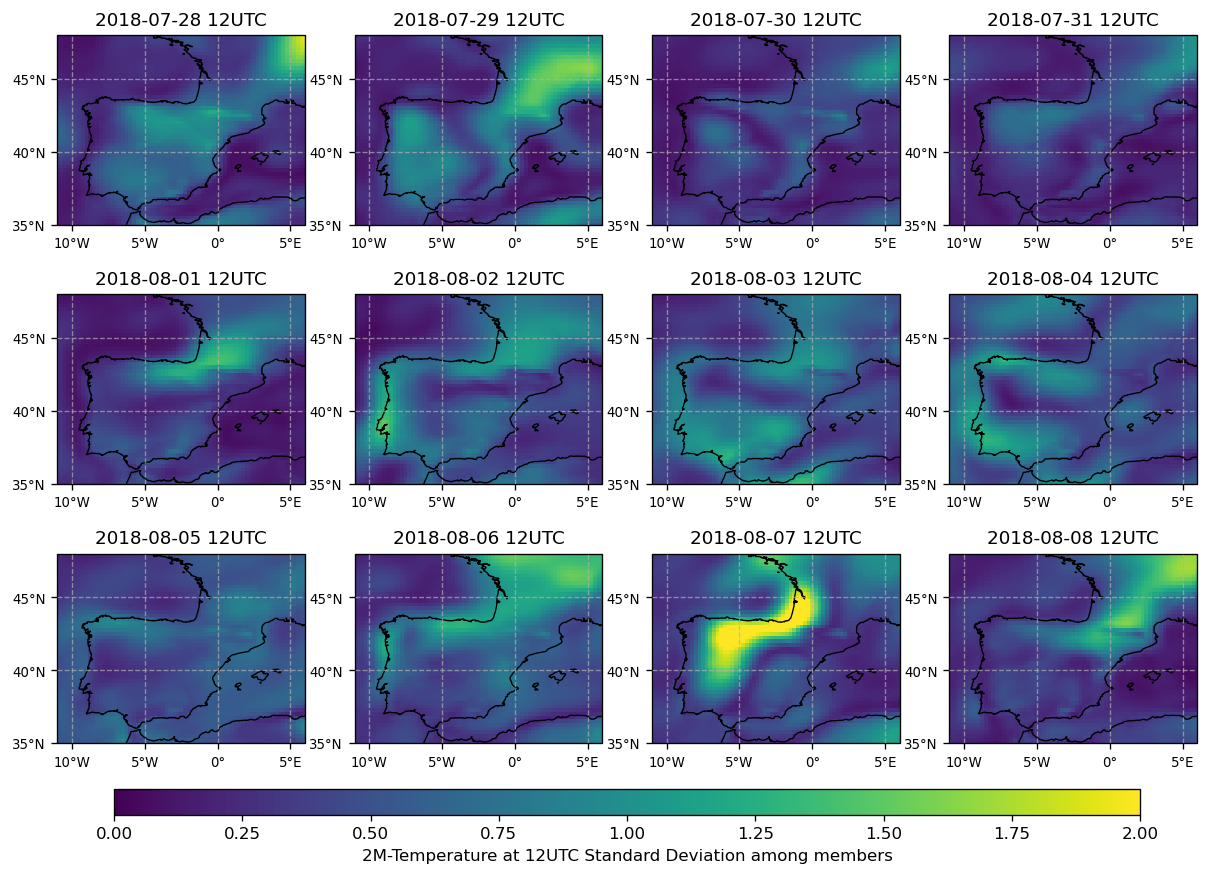

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

data= ens_std_iberia[6:19] 

# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(10,8.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

colors = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = data.lat, data.lon
nLons = np.arange(-180, 181, 5)
nLats = np.arange(-90, 91, 5)

# Loop through subplots
for i, ax in enumerate(axes.flatten()):

    try:
        ax.set_title( data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)

        ax.set_xticks(nLons, crs=ccrs.PlateCarree())
        ax.set_yticks(nLats, crs=ccrs.PlateCarree())
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_ylim([35, 48])
        ax.set_xlim([-11, 6])
    
        ax.set_facecolor('0.9')
        ax.coastlines(lw=0.8, color='k')  
        ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

        # format the ticks as e.g 60°W
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())

        ax.set_aspect(1)

        # Explicitly pass the ax parameter to contourf
        #h = ax.contourf(lon, lat, data[i], cmap='Spectral_r', levels=lev, extend='both', alpha=1.0) 
        h = ax.pcolormesh(lon, lat, data[i], cmap='viridis', vmax=2.0, vmin=0)
    except:
        f.delaxes(axes.flatten()[i])

# Adjust size
f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.0, right=0.95, bottom=0.05, top=0.95)

# Add common colorbar
#cbar = plt.colorbar(h, ax=axes, label='BIAS in 2M-Temperature at 12UTC (FourCastNet - ERA5)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)
cbar = plt.colorbar(h, ax=axes, label='2M-Temperature at 12UTC Standard Deviation among members', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

#save figure
#plt.savefig('2018HW_Iberia_pannel_bias_FourCastNet_wrt_ERA5.pdf',bbox_inches='tight')
plt.savefig('2018HW_Iberia_pannel_spread_factual_leadtimes_1-6days.pdf',bbox_inches='tight')

In [40]:
def load_data_deltas(var, init_times, models):
    var_inits_model = []
    for model in models:
        print(model)
        var_inits = []
        for t0 in init_times:
            yyyymmddhh = t0.strftime('%Y%m%d%H')    
            file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_PGW_{model}_{yyyymmddhh}.nc'
            ds = xr.open_dataset(file)[var]
            var_inits.append(ds)
        var_inits_model.append(xr.concat(var_inits, dim='init_time'))
    merged_dataset = xr.concat(var_inits_model, dim='model')

    return merged_dataset.assign_coords(init_time=init_times,model=models)

z500_cf = load_data_deltas('z500',init_times, models)

awi-cm-1-1-mr
bcc-csm2-mr
cams-csm1-0
canesm5-1
cas-esm2-0
cmcc-cm2-hr4
cmcc-cm2-sr5
cmcc-esm2
ec-earth3-cc
ec-earth3-veg-lr
ec-earth3-veg
ec-earth3


In [41]:
def load_data(var, init_times):
    var_inits = []
    for t0 in init_times:
        yyyymmddhh = t0.strftime('%Y%m%d%H')    
        file = f'/home/bernatj/Data/ai-forecasts/fcst/{yyyymmddhh}/{var}_fcnv2_{yyyymmddhh}.nc'
        ds = xr.open_dataset(file)[var]
        var_inits.append(ds)
    merged_dataset = xr.concat(var_inits, dim='init_time')
    return merged_dataset.assign_coords(init_time=init_times)

z500 = load_data('z500', init_times)

In [49]:
z500_ai_europe = flip_lon_360_2_180(z500[:,2::4],z500.lon).sel(lat=slice(70,20),lon=slice(-40,50)).mean('init_time') 
z500_ai_cf_europe = flip_lon_360_2_180(z500_cf[:,2::4],z500.lon).sel(lat=slice(70,20),lon=slice(-40,50)).mean(['init_time','model'])


In [50]:
diff_pgw_z500 = z500_ai_europe - z500_ai_cf_europe

/tmp/ipykernel_4171164/4249015176.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap('RdBu_r', 256)


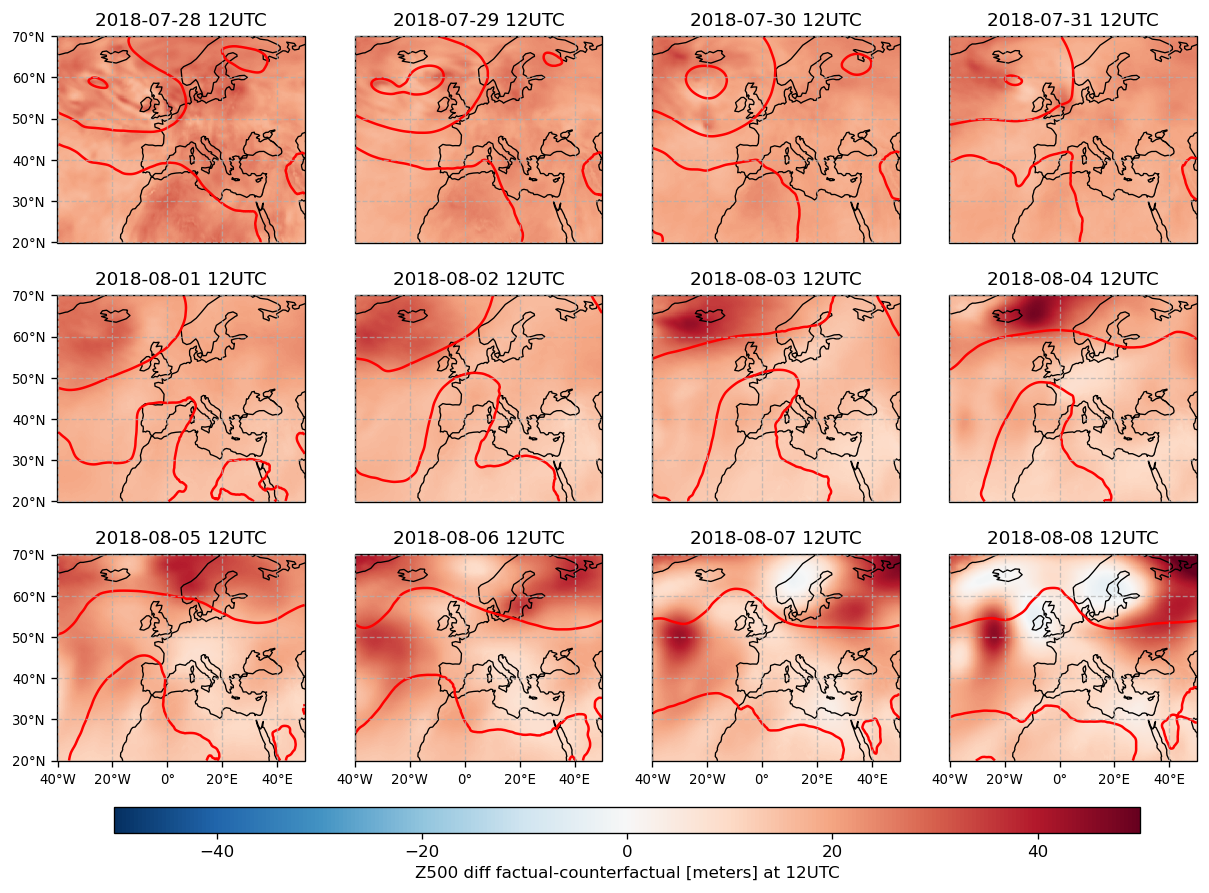

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 7

data= diff_pgw_z500/9.806

# Create subplots with shared y-axis and manually share x-axis
f, axes = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(10,8.5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None)))

colors = mpl.cm.get_cmap('RdBu_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = data.lat, data.lon
nLons = np.arange(-180, 181, 20)
nLats = np.arange(-90, 91, 10)

# Loop through subplots
for i, ax in enumerate(axes.flatten()):

    try:
        ax.set_title( data.time.dt.strftime('%Y-%m-%d %HUTC').values[i], fontsize=11)

        if i%4 ==0:
            ax.set_yticks(nLats, crs=ccrs.PlateCarree())
        if i>=4*2:
            ax.set_xticks(nLons, crs=ccrs.PlateCarree())

        ax.tick_params(axis='both', which='major', labelsize=8)
    
        ax.set_facecolor('0.9')
        ax.coastlines(lw=0.8, color='k')  
        ax.gridlines(linestyle='--', zorder=3, alpha=0.7, xlocs=nLons, ylocs=nLats)

        # format the ticks as e.g 60°W
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())

        ax.set_aspect(1.5)

        # Explicitly pass the ax parameter to contourf
        h = ax.contour(lon, lat, z500_ai_europe[i]/9.806, levels=[5400,5700,5900], colors='r') 
        h = ax.pcolormesh(lon, lat, data[i], cmap='RdBu_r', vmax=50, vmin=-50)
        
    except:
        f.delaxes(axes.flatten()[i])

# Adjust size
f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.0, right=0.95, bottom=0.05, top=0.95)

# Add common colorbar
#cbar = plt.colorbar(h, ax=axes, label='BIAS in 2M-Temperature at 12UTC (FourCastNet - ERA5)', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)
cbar = plt.colorbar(h, ax=axes, label='Z500 diff factual-counterfactual [meters] at 12UTC', pad=0.05, orientation='horizontal', shrink=0.9, aspect=40)

#save figure
#plt.savefig('2018HW_Iberia_pannel_bias_FourCastNet_wrt_ERA5.pdf',bbox_inches='tight')
#plt.savefig('2018HW_Iberia_pannel_diff_FourCastNet_factual-counterfactual_ERA5.pdf',bbox_inches='tight'